In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import backend as K
from tensorflow.keras import Model

import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 

import sys

In [2]:
df = pd.read_excel("./data/example_failure_data_sets.xlsx", sheet_name="CSR3", engine="openpyxl")
df2 = pd.read_excel("./data/example_failure_data_sets.xlsx", sheet_name="S2", engine="openpyxl")

df2["FT"]  = [x/ max(df2["FT"] ) for x in df2["FT"] ]
df["FT"]  = [x/ max(df["FT"] ) for x in df["FT"] ]

In [3]:
df2["ds"]  = [1 for x in df2["FT"] ]
df["ds"]  = [0 for x in df["FT"] ]

In [4]:
#from tensorflow tutorial
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=df[["FT"]], val_df=df2[["FT"]], test_df=df2[["FT"]],
               label_columns=["FN"]):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])
    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        inputs = tf.stack([labels[:, :, self.column_indices[name]] for name in ["FT"]], axis=-1)
        
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        return inputs, labels


    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
        # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
        # And cache it for next time
            self._example = result
        return result

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
          data=data,
          targets=None,
          sequence_length=self.total_window_size,
          sequence_stride=1,
          shuffle=False,
          batch_size=32,)

        ds = ds.map(self.split_window)

        return ds
#     WindowGenerator.split_window = split_window
#     WindowGenerator.make_dataset = make_dataset
#     WindowGenerator.train = train
#     WindowGenerator.val = val
#     WindowGenerator.test = test
#     WindowGenerator.example = example

In [5]:
class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units, activation="elu")
        # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(num_features)

    def warmup(self, inputs):
        # inputs.shape => (batch, time, features)
        # x.shape => (batch, lstm_units)
        x, *state = self.lstm_rnn(inputs)

        # predictions.shape => (batch, features)
        prediction = self.dense(x)
        return prediction, state
    
    def call(self, inputs, training=None):
        # Use a TensorArray to capture dynamically unrolled outputs.
        predictions = []
        # Initialize the LSTM state.
        prediction, state = self.warmup(inputs)

        # Insert the first prediction.
        predictions.append(prediction)

        # Run the rest of the prediction steps.
        for n in range(1, self.out_steps):
            # Use the last prediction as input.
            x = prediction
            # Execute one lstm step.
            x, state = self.lstm_cell(x, states=state,
                                      training=training)
            # Convert the lstm output to a prediction.
            prediction = self.dense(x)
            # Add the prediction to the output.
            predictions.append(prediction)

        # predictions.shape => (time, batch, features)
        predictions = tf.stack(predictions)
        # predictions.shape => (batch, time, features)
        predictions = tf.transpose(predictions, [1, 0, 2])
        return predictions

# FeedBack.call = call

# FeedBack.warmup = warmup

k = 1
num_features = 2
i = 0
# multi_window = WindowGenerator(
#         input_width=k, label_width=k, shift=k, train_df=df2[["FT", "FN"]].iloc[:int( (i + 1)/5 * len(df2["FT"]))], val_df=df2[["FT", "FN"]].iloc[int(i/5 * len(df2["FT"])): int( (i +1)/5 * len(df2["FT"]))], test_df=df2[["FT", "FN"]].iloc[int((i + 1)/5 * len(df2["FT"])): int( (i+2)/5 * len(df2["FT"]))], 
#         label_columns=["FN"])

# feedback_model = FeedBack(units=16, out_steps=k)
# prediction, state = feedback_model.warmup(multi_window.example[0])
# feedback_model.compile(loss=tf.losses.MeanSquaredError(),
#                 optimizer=tf.keras.optimizers.Adam(0.01),
#                 metrics=["mse"])

In [49]:
k = 1

#don't wipe and initialize with other data
mse = []
pmse = []


#wipe each iteration and train on all available data
# scratch_mse= []
# scratch_pmse = []


#wipe each time but train on other data too
# transfer_mse = []
# transfer_pmse = []


#don't wipe and train on window of data
# inc_mse = []
# inc_pmse = []


datasets = [ ("CSR3", "CSR1") ]#, ("CSR3", "CSR2"), ("CSR3", "S2"), ("S2", "CSR1"), ("S2", "CSR3"), ("SYS2", "CSR1"), ("SYS2", "CSR3")  ]

training_datasets = ["CSR3"]#, "SYS2", "S2"]



for d in datasets:
    feedback_model = FeedBack(units=8, out_steps=k)
    prediction, state = feedback_model.warmup(multi_window.example[0])
    feedback_model.compile(loss=tf.losses.MeanSquaredError(),
            optimizer=tf.keras.optimizers.Adam(0.1),
            metrics=["mse"])
    count = 1
    for dt in training_datasets:
        df = pd.read_excel("./data/example_failure_data_sets.xlsx", sheet_name=dt, engine="openpyxl")
        df["FT"]  = [x/ max(df["FT"] ) for x in df["FT"] ]
        df["ds"]  = [count for x in df["FT"] ]
        count+=1


        multi_window = WindowGenerator(
                input_width=k, label_width=k, shift=k, train_df=df[["FT", "FN", "ds"]], val_df=df[["FT", "FN", "ds"]], test_df=df[["FT", "FN", "ds"]], 
                label_columns=["FN"])
        

        feedback_model.fit(multi_window.train, epochs=500, callbacks=tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.001, patience=20), verbose=0)



    
    
    df = pd.read_excel("./data/example_failure_data_sets.xlsx", sheet_name=d[0], engine="openpyxl")
    df2 = pd.read_excel("./data/example_failure_data_sets.xlsx", sheet_name=d[1], engine="openpyxl")
    df2["FT"]  = [x/ max(df2["FT"] ) for x in df2["FT"] ]
    df["FT"]  = [x/ max(df["FT"] ) for x in df["FT"] ]
    df2["ds"]  = [0 for x in df2["FT"] ]
    df["ds"]  = [1 for x in df["FT"] ]
    
    
    
#     multi_window = WindowGenerator(
#             input_width=k, label_width=k, shift=k, train_df=df[["FT", "FN", "ds"]], val_df=df[["FT", "FN", "ds"]], test_df=df2[["FT", "FN", "ds"]], 
#             label_columns=["FN"])
#     feedback_model = FeedBack(units=16, out_steps=k)
#     prediction, state = feedback_model.warmup(multi_window.example[0])
#     feedback_model.compile(loss=tf.losses.MeanSquaredError(),
#                 optimizer=tf.keras.optimizers.Adam(0.1),
#                 metrics=["mse"])

#     feedback_model.fit(multi_window.train, epochs=500, callbacks=tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.001, patience=20), verbose=0)


#     inc_model = FeedBack(units=16, out_steps=k)
#     prediction, state = inc_model.warmup(multi_window.example[0])
#     inc_model.compile(loss=tf.losses.MeanSquaredError(),
#                 optimizer=tf.keras.optimizers.Adam(0.1),
#                 metrics=["mse"])




    for i in range(0, 9):
    #     multi_window = WindowGenerator(
    #         input_width=k, label_width=k, shift=k, train_df=df2[["FT", "FN"]].iloc[int( i /5 * len(df2["FT"])):int( (i + 1)/5 * len(df2["FT"]))], val_df=df2[["FT", "FN"]].iloc[ int(i /5 * len(df2["FT"])):int( (i + 2)/5 * len(df2["FT"]))], test_df=df2[["FT", "FN"]].iloc[int((i + 1)/5 * len(df2["FT"])): int( (i+2)/5 * len(df2["FT"]))], 
    #         label_columns=["FN"])



#         multi_window = WindowGenerator(
#             input_width=k, label_width=k, shift=k, train_df=df[["FT", "FN", "ds"]], val_df=df[["FT", "FN", "ds"]], test_df=df2[["FT", "FN", "ds"]], 
#             label_columns=["FN"])
#         transfer_model = FeedBack(units=8, out_steps=k)
#         prediction, state = transfer_model.warmup(multi_window.example[0])
#         transfer_model.compile(loss=tf.losses.MeanSquaredError(),
#                     optimizer=tf.keras.optimizers.Adam(0.1),
#                     metrics=["mse"])

#         transfer_model.fit(multi_window.train, epochs=500, callbacks=tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.001, patience=20), verbose=0)
        
        multi_window = WindowGenerator(
            input_width=k, label_width=k, shift=k, train_df=df2[["FT", "FN", "ds"]].iloc[int( i /10 * len(df2["FT"])):int( (i + 1)/10 * len(df2["FT"]))], val_df=df2[["FT", "FN", "ds"]].iloc[:int( (i + 2)/10 * len(df2["FT"]))], test_df=df2[["FT", "FN", "ds"]].iloc[int((i + 1)/10 * len(df2["FT"])): int( (i+2)/10 * len(df2["FT"]))], 
            label_columns=["FN"])
        
        
#         transfer_model.fit(multi_window.train, epochs=500, callbacks=tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.001, patience=20), verbose=0)

#         multi_window = WindowGenerator(
#             input_width=k, label_width=k, shift=k, train_df=df2[["FT", "FN", "ds"]].iloc[int( i /10 * len(df2["FT"])):int( (i + 1)/10 * len(df2["FT"]))], val_df=df2[["FT", "FN", "ds"]].iloc[ int(i /10 * len(df2["FT"])):int( (i + 2)/10 * len(df2["FT"]))], test_df=df2[["FT", "FN", "ds"]].iloc[int((i + 1)/10 * len(df2["FT"])): int( (i+2)/10 * len(df2["FT"]))], 
#             label_columns=["FN"])

    #     feedback_model = FeedBack(units=4, out_steps=k)
    #     prediction, state = feedback_model.warmup(multi_window.example[0])
    #     feedback_model.compile(loss=tf.losses.MeanSquaredError(),
    #             optimizer=tf.keras.optimizers.Adam(0.1),
    #             metrics=["mse"])

        feedback_model.fit(multi_window.train, epochs=500, callbacks=tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.001, patience=20), verbose=0)
#         inc_model.fit(multi_window.train, epochs=500, callbacks=tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.001, patience=20), verbose=0)


#         scratch_lstm = FeedBack(units=8, out_steps=k)
#         prediction, state = scratch_lstm.warmup(multi_window.example[0])
#         scratch_lstm.compile(loss=tf.losses.MeanSquaredError(),
#                     optimizer=tf.keras.optimizers.Adam(0.1),
#                     metrics=["mse"])

#         scratch_window = WindowGenerator(
#                 input_width=k, label_width=k, shift=k, train_df=df2[["FT", "FN"]].iloc[:int( (i + 1)/10 * len(df2["FT"]))], val_df=df2[["FT", "FN"]].iloc[:int( (i + 2)/10 * len(df2["FT"]))], test_df=df2[["FT", "FN"]].iloc[int((i + 1)/10 * len(df2["FT"])): int( (i+2)/10 * len(df2["FT"]))], 
#                 label_columns=["FN"])

#         scratch_lstm.fit(scratch_window.train, epochs=500, callbacks=tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.001, patience=20), verbose=0)

        
#         transfer_mse.append(transfer_model.evaluate(multi_window.val))
#         transfer_pmse.append(transfer_model.evaluate(multi_window.test))

#         inc_mse.append(inc_model.evaluate(multi_window.val))
#         inc_pmse.append(inc_model.evaluate(multi_window.val))
        
#         scratch_mse.append(scratch_lstm.evaluate(scratch_window.val))
#         scratch_pmse.append(scratch_lstm.evaluate(scratch_window.test))

        mse.append(feedback_model.evaluate(multi_window.val))
        pmse.append(feedback_model.evaluate(multi_window.test))


2/2 [==============================] - 0s 2ms/step - loss: 123.9356 - mse: 123.9356


In [13]:

# results = {}
# idx = 0
# for d in datasets:#, "relu", "sigmoid", "tanh"]:
#     df = pd.read_excel("./data/example_failure_data_sets.xlsx", sheet_name=d[0], engine="openpyxl")
#     df2 = pd.read_excel("./data/example_failure_data_sets.xlsx", sheet_name= d[1], engine="openpyxl")

#     df_temp = pd.DataFrame()

#     df_temp["pmse scratch"] = [x[0] for x in scratch_mse[idx * 9: (idx + 1)* 9]]
#     df_temp["mse scratch"]= [x[0] for x in scratch_pmse[idx * 9: (idx + 1)* 9]]
#     df_temp["pmse incremental 1"] = [x[0] for x in inc_mse[idx * 9: (idx + 1)* 9]]
#     df_temp["mse incremenal 1"] = [x[0] for x in inc_pmse[idx * 9: (idx + 1)* 9]]
#     df_temp["pmse transfer"] = [x[0] for x in transfer_mse[idx * 9: (idx + 1)* 9]]
#     df_temp["mse transfer"] = [x[0] for x in transfer_pmse[idx * 9: (idx + 1)* 9]]
#     df_temp["mse incremental 2"] = [x[0] for x in mse[idx * 9: (idx + 1)* 9]]
#     df_temp["pmse incremental 2"] = [x[0] for x in pmse[idx * 9: (idx + 1)* 9]]


#     results[d] = df_temp.copy()
#     idx +=1

    
# with pd.ExcelWriter("./results/rnn_results_stats.xlsx") as ex:
#     for i in results.keys():
#         results[i].to_excel(ex, "{}, {}".format(i[0], i[1]), index=False)



([<matplotlib.axis.YTick at 0x167387c70>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

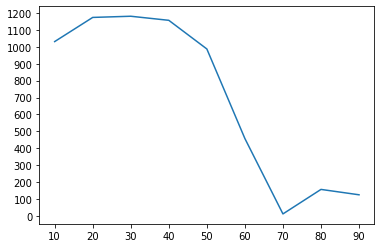

In [51]:
# print(len(mse))
# print(pmse)

pp = plt.plot([x for x in range(10,100,10)], [x[0] for x in pmse])

plt.yticks([0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200])# pp2 = plt.plot([x[0] for x in scratch_pmse])

([<matplotlib.axis.YTick at 0x163e196a0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

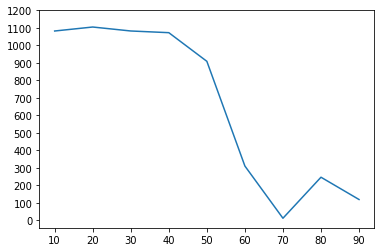

In [31]:

pp = plt.plot([x for x in range(10,100,10)], [x[0] for x in pmse])

plt.yticks([0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200])

In [ ]:
# list(multi_window.train)[0][1]
print(mse)
print(pmse)

plt.plot([x[0] for x in pmse])

In [ ]:
feedback_model.predict(multi_window.test)

In [ ]:

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(64, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])







lstm_model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(0.01),
                metrics=["mse", "mae"])

In [ ]:
k = 2
wide_window = WindowGenerator(
    input_width=k, label_width=k, shift=1, train_df=df[["FT", "FN"]], val_df=df2[["FT", "FN"]], test_df=df2[["FT", "FN"]], 
    label_columns=["FN"])
wide_window

# lstm_model.fit(wide_window.train, epochs=500, validation_data=wide_window.val, callbacks=tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.0001, patience=5), verbose=0)




In [ ]:
# print(lstm_model.evaluate(wide_window.test, verbose=0))

#int(i/10 * len(df2["FT"]))

df = pd.read_excel("./data/example_failure_data_sets.xlsx", sheet_name="CSR3", engine="openpyxl")
df2 = pd.read_excel("./data/example_failure_data_sets.xlsx", sheet_name="CSR1", engine="openpyxl")

In [ ]:
k = 4
for i in range(0, 9):
    lstm_model = tf.keras.models.Sequential([
        # Shape [batch, time, features] => [batch, time, lstm_units]
        tf.keras.layers.LSTM(128, activation="elu", return_sequences=True),
        # Shape => [batch, time, features]
        tf.keras.layers.Dense(units=1)
    ])

    lstm_model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mse", "mae"])
    
    
    wide_window = WindowGenerator(
        input_width=k, label_width=k, shift=2, train_df=df[["FT", "FN"]], val_df=df2[["FT", "FN"]].iloc[int(i/10 * len(df2["FT"])): int( (i +1)/10 * len(df2["FT"]))], test_df=df2[["FT", "FN"]].iloc[int((i + 1)/10 * len(df2["FT"])): int( (i+2)/10 * len(df2["FT"]))], 
        label_columns=["FN"])
    lstm_model.fit(wide_window.train, epochs=500, validation_data=wide_window.val, callbacks=tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.001, patience=20), verbose=0)


    
    wide_window = WindowGenerator(
        input_width=k, label_width=k, shift=2, train_df=df2[["FT", "FN"]].iloc[:int( (i + 1)/10 * len(df2["FT"]))], val_df=df2[["FT", "FN"]].iloc[int(i/10 * len(df2["FT"])): int( (i +1)/10 * len(df2["FT"]))], test_df=df2[["FT", "FN"]].iloc[int((i + 1)/10 * len(df2["FT"])): int( (i+2)/10 * len(df2["FT"]))], 
        label_columns=["FN"])


    lstm_model.fit(wide_window.train, epochs=500, validation_data=wide_window.val, callbacks=tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.001, patience=20), verbose=0)
    
    print(lstm_model.evaluate(wide_window.test, verbose=0))
